# Examples for EPTools
@copyright by Runduo Liang (Aujust)

In [4]:
import os, sys
sys.path.append('/Users/liangrunduo/heasoft-6.34/aarch64-apple-darwin23.5.0/lib/python')
sys.path.append('/Users/liangrunduo/EP/Tools/EPTools') #Air
sys.path.append('/Users/liangrunduo/Desktop/Aujust/NAOC/EP/EPTools') #Pro
from astropy.cosmology import Planck18
from astropy.coordinates import SkyCoord
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ligo.skymap.io.fits import read_sky_map, write_sky_map
import ligo.skymap.postprocess as postprocess
from astropy.io.fits import writeto
import xspec as xs
import EPTools

In [8]:
EPTools.flx2lum(1e-9,Planck18.luminosity_distance(0.6).value*1e6)

1.5817233789438092e+48

## Crossmatch

In [2]:
import sys
sys.path.append('/Users/liangrunduo/heasoft-6.34/aarch64-apple-darwin23.5.0/lib/python')
import EPTools
from astropy.coordinates import SkyCoord
from EPTools.utils import *
import numpy as np
from astropy.cosmology import Planck18
import matplotlib.pyplot as plt
from astroquery.vizier import Vizier, VizierClass
from ligo.skymap.postprocess import crossmatch
from astropy.table import Table
from ligo.skymap.io.fits import read_sky_map
import re
import pickle
#!source ~/.bashrc heasoft
#from xspec import *
#from astropy.config import create_config_file
#from astropy.config import get_config_dir
#create_config_file('astropy')
#get_config_dir()


In [4]:
plan_root = '/Volumes/T7/Shared_Files/EP/EP-TA-data/S250206dm/'
wxt_obs_name = 'wxt_obs_list.csv'
fxt_obs_name = 'fxt_obs_list.csv'

wxt_plan = EPTools.make_EPPlan(plan_root+wxt_obs_name,instrument='WXT')
fxt_plan = EPTools.make_EPPlan(plan_root+fxt_obs_name,instrument='FXT')

In [5]:
with open(plan_root+'S250206dm_WXT_plan.pkl','wb') as handle:
    pickle.dump(wxt_plan,handle,protocol=pickle.HIGHEST_PROTOCOL)
    handle.close()
with open(plan_root+'S250206dm_FXT_plan.pkl','wb') as handle:
    pickle.dump(fxt_plan,handle,protocol=pickle.HIGHEST_PROTOCOL)
    handle.close()

### Fit WXT & FXT sensitivity vs. expo time

[5.49101782e-11 8.12917739e-01]


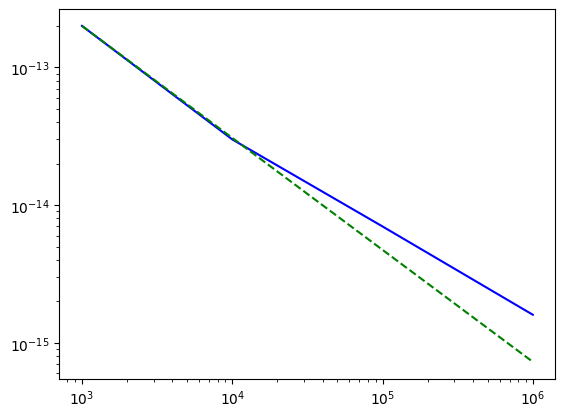

In [ ]:
from scipy.optimize import curve_fit
#WXT
#xdata = np.array([10,100,1000])
#ydata = np.array([9e-10,1.3e-10,2.6e-11])

#FXT
xdata = np.array([1e3,1e4,1e5,1e6])
ydata = np.array([2e-13,3e-14,7e-15,1.6e-15])


def pw(x, norm,p):
    return norm * x**-p

popt, pcov = curve_fit(pw, xdata, ydata)
print(popt)
plt.plot(xdata, ydata, 'b-', label='data')
plt.plot(xdata, pw(xdata, *popt), 'g--')
plt.xscale('log')
plt.yscale('log')


### Get Catalogue

In [5]:
'Convert milliquas into astropy.table'
#with open('/Users/liangrunduo/EP/Catalogue/milliquas.txt') as f:
#    data = f.read()
table = Table.read('/Users/liangrunduo/Desktop/Aujust/NAOC/EP/Crossmatch/catalogs/Milliquas.fits',format='fits')
table.write('/Users/liangrunduo/Desktop/Aujust/NAOC/EP/Crossmatch/catalogs/Milliquas.csv', format="csv", overwrite=True)

In [7]:
'Get ALLWISE AGN Catalogue via Vizier'
catalog_id = "J/ApJS/221/12"  #ALLWISE AGN Catalogue
#catalog_id = "IX/57/xmm4xmm"  #XMM-Newton Serendipitous Source Catalog
vizier = VizierClass(
    row_limit=-1,
    columns=['recno', 'WISEA', '_RAJ2000', '_DEJ2000', 'W1-W2','gmag','z','f_z','HMQ'])
cat, = vizier.get_catalogs(catalog_id)
cat.sort('recno')  # sort catalog so that doctest output is stable
del cat['recno']
dist = Planck18.luminosity_distance(cat['z'])
cat.write('/Users/liangrunduo/Desktop/Aujust/NAOC/EP/Crossmatch/catalogs/WISE_AGN.csv', format="csv", overwrite=True)
#coordinates = SkyCoord(cat['_RAJ2000'], cat['_DEJ2000'], dist)
coordinates = SkyCoord(cat['_RAJ2000'], cat['_DEJ2000'])

### Crossmatch with GW

In [3]:
# Load the CSV file into an Astropy Table
wise_agn_table = Table.read("/Users/liangrunduo/Desktop/Aujust/NAOC/EP/Crossmatch/catalogs/WISE_AGN.csv", format="csv")
milliquas_table = Table.read("/Users/liangrunduo/Desktop/Aujust/NAOC/EP/Crossmatch/catalogs/Milliquas.csv", format="csv")

In [ ]:
skymap = read_sky_map('https://gracedb.ligo.org/api/superevents/S241102br/files/bayestar.multiorder.fits',moc=True)
#skymap = read_sky_map('/Users/liangrunduo/EP/GW/S241102br_skymap.fits',moc=True)
milliquas_table_valid = milliquas_table[milliquas_table['Z']>0]
dist = Planck18.luminosity_distance(milliquas_table_valid['Z'])
coordinates = SkyCoord(milliquas_table_valid['RA']*u.deg, milliquas_table_valid['DEC']*u.deg, dist)
result = crossmatch(skymap, coordinates)
print(milliquas_table_valid[result.searched_prob_vol < 0.9])

wise_agn_table_valid = wise_agn_table[wise_agn_table['z']>0]
dist = Planck18.luminosity_distance(wise_agn_table_valid['z'])
coordinates = SkyCoord(wise_agn_table_valid['_RAJ2000']*u.deg, wise_agn_table_valid['_DEJ2000']*u.deg, dist)
result = crossmatch(skymap, coordinates)
print(wise_agn_table_valid[result.searched_prob_vol < 0.9])

     RA        DEC          NAME       ...         LOBE1          LOBE2
----------- --------- ---------------- ... ---------------------- -----
346.9886014 40.277528 PBC J2307.9+4015 ... XMMSL J230757.0+401643    --
  _RAJ2000   _DEJ2000         WISEA        W1-W2 gmag   z   f_z       HMQ       
----------- ---------- ------------------- ----- ---- ----- --- ----------------
346.9885791 40.2775306 J230757.25+401639.1  0.79   -- 0.073   s PBC J2307.9+4015


In [ ]:
url = 'https://gracedb.ligo.org/api/superevents/S190814bv/files/bayestar.multiorder.fits'
skymap = read_sky_map(url, moc=True)
result = crossmatch(skymap, coordinates)
print(wise_agn_table[result.searched_prob_vol < 0.9])

 _RAJ2000   _DEJ2000         WISEA        W1-W2 gmag  z  f_z HMQ
---------- ---------- ------------------- ----- ---- --- --- ---
15.3030541 -2.1704141 J010112.73-021013.4  1.71   --  --  --  --


In [ ]:
d = 1000/5.5027
f = 3.66e-11
print(flx2lum(f,d))

f = 1e-11
d = Planck18.luminosity_distance(2.597000).value * 1e6
print(flx2lum(f,d))



1.4462399941120547e+32
5.7218389587855725e+47


## Plot SED of EP and multiwavelength data

## SBO

In [21]:
ra, dec = 41.0129,	53.4745
cros = EPTools.Crossmatch()
data = cros.ztf_lc('%s %s'%(ra,dec),band='r',match_rad=1)
data

oid,expid,hjd,mjd,mag,magerr,catflags,filtercode,ra,dec,chi,sharp,filefracday,field,ccdid,qid,limitmag,magzp,magzprms,clrcoeff,clrcounc,exptime,airmass,programid
,,d,d,mag,mag,,,deg,deg,,,,,,,mag,mag,mag,,,s,,
int64,int32,float64,float64,float32,float32,int32,object,float64,float64,float32,float32,int64,int32,uint8,uint8,float32,float32,float32,float32,float32,float32,float32,int32
776206400016063,52448103,2458278.9767788886,58278.4810301,17.637304,0.02268365,0,zr,41.0124872,53.4745103,1.03,0.14,20180609480394,776,6,4,19.09,26.219074,0.0203123,0.06642518,9.543806e-06,30.0,2.024,1
776206400016063,52748047,2458281.9763161982,58281.4804745,17.700039,0.02346613,0,zr,41.0124798,53.4746302,1.055,0.048,20180612479977,776,6,4,19.38,26.274462,0.018475547,0.07393416,7.965479e-06,30.0,1.935,1
776206400016063,52947188,2458283.967796108,58283.4718866,17.597656,0.022214932,0,zr,41.0125244,53.4746074,1.136,0.01,20180614471875,776,6,4,19.98,26.240608,0.017900819,0.07840789,7.4509976e-06,30.0,1.971,1
776206400016063,53347659,2458287.972657532,58287.4765972,17.59562,0.022191372,0,zr,41.0125713,53.4745846,1.488,-0.043,20180618476586,776,6,4,19.54,26.274858,0.018037869,0.07734203,7.594909e-06,30.0,1.805,1
776206400016063,53446780,2458288.963901455,58288.4678009,17.611832,0.022380272,0,zr,41.0126379,53.4744892,2.147,0.063,20180619467789,776,6,4,20.01,26.237202,0.017170142,0.093415596,6.830708e-06,30.0,1.866,1
776206400016063,53547468,2458289.9708300894,58289.4746875,17.77782,0.02450927,0,zr,41.0125969,53.4745846,3.841,0.261,20180620474676,776,6,4,20.28,26.268808,0.013118421,0.08424545,4.039758e-06,30.0,1.772,1
776206400016063,54343079,2458297.9273125064,58297.4307986,17.644812,0.022774626,0,zr,41.012549,53.4745499,0.986,0.058,20180628430787,776,6,4,19.36,26.237797,0.01810784,0.07447087,7.638561e-06,30.0,2.007,1
776206400016063,54445098,2458298.9475501766,58298.4509838,17.638935,0.022703355,0,zr,41.0125799,53.4745207,1.641,0.09,20180629450972,776,6,4,19.58,26.208164,0.016406612,0.08931388,6.3082357e-06,30.0,1.765,1


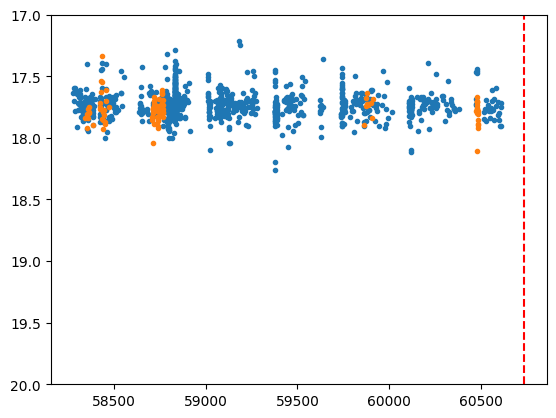

In [22]:
from astropy.time import Time
t_now = Time.now()
for oid in np.unique(data['oid']):
    mjd = data[data['oid']==oid]['mjd']
    mag = data[data['oid']==oid]['mag']
    plt.plot(mjd,mag,'.')
    plt.ylim([20,17])
plt.axvline(t_now.mjd,color='r',ls='--')